In [1]:
# import packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn import tree

np.random.seed(42)

In [2]:
# read input files

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [3]:
# check duplicated PassengerId

id_unique = len(set(df_train.PassengerId))
id_count = df_train.PassengerId.shape[0]
print('No duplicated Id?', id_unique == id_count)

No duplicated Id? True


In [4]:
# import modules from local directory

import sys
sys.path.append('..\\modules')
from uzila_func import pre_process as pr

In [5]:
# look for missing values

missing_values = pr.TableMissVal(df_train, df_test)

         miss_train            miss_test           
              Total Percentage     Total Percentage
Cabin         687.0  77.104377     327.0  78.229665
Age           177.0  19.865320      86.0  20.574163
Embarked        2.0   0.224467       NaN        NaN
Fare            NaN        NaN       1.0   0.239234


In [6]:
# fill missing cabins with new category

df_train.Cabin.fillna('X0', inplace=True)
df_test.Cabin.fillna('X0', inplace=True)

In [7]:
# get titles and surnames from names, then drop names

def ExtractName(df):
    df['Title'] = df.Name.map(lambda x: x.split(',')[1].split('.')[0].strip())
    df['Surname'] = df.Name.map(lambda x: x.split(',')[0].strip())
    df.drop('Name', axis=1, inplace=True)

ExtractName(df_train)
ExtractName(df_test)

In [8]:
# fill missing ages based on title

titles = df_train['Title'].unique()
age_median_per_title = dict()

for t in titles:
    age_median_per_title[t] = df_train.loc[df_train.Title==t, 'Age'].median()

print(age_median_per_title)

def FillAge(df):
    df.Age.fillna(-1, inplace=True)
    for index, row in df.iterrows():
        if row['Age']==-1:
            df.loc[index, 'Age'] = age_median_per_title[row['Title']]
            
FillAge(df_train)
FillAge(df_test)

{'Mr': 30.0, 'Mrs': 35.0, 'Miss': 21.0, 'Master': 3.5, 'Don': 40.0, 'Rev': 46.5, 'Dr': 46.5, 'Mme': 24.0, 'Ms': 28.0, 'Major': 48.5, 'Lady': 48.0, 'Sir': 49.0, 'Mlle': 24.0, 'Col': 58.0, 'Capt': 70.0, 'the Countess': 33.0, 'Jonkheer': 38.0}


In [9]:
# fill missing embarkeds with mode

df_train['Embarked'].fillna('S', inplace=True)
df_test['Embarked'].fillna('S', inplace=True)

In [10]:
# fill missing fares based on pclass

pclass = df_train['Pclass'].unique()
fare_median_per_pclass = dict()

for c in pclass:
    fare_median_per_pclass[c] = df_train.loc[df_train.Pclass==c, 'Fare'].median()

print(fare_median_per_pclass)

def FillFare(df):
    df.Fare.fillna(-1, inplace=True)
    for index, row in df.iterrows():
        if row['Fare']==-1:
            df.loc[index, 'Fare'] = fare_median_per_pclass[row['Pclass']]
            
FillFare(df_train)
FillFare(df_test)

{3: 8.05, 1: 60.287499999999994, 2: 14.25}


In [11]:
# check missing values

missing_values = pr.TableMissVal(df_train, df_test)

Empty DataFrame
Columns: [(miss_train, Total), (miss_train, Percentage), (miss_test, Total), (miss_test, Percentage)]
Index: []


### 1. Gender Classifier

In [12]:
# group survival based on gender

print('Survival on sex:\n', df_train.groupby(['Sex', 'Survived']).Survived.count())

Survival on sex:
 Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64


Predict dead on male, survive on female.

In [13]:
# make the estimator

class GenderClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def _replacement(self, x):
        if x=='male': return 0
        if x=='female': return 1
    def predict(self, X, y=None):
        return([self._replacement(x) for x in X['Sex']])

In [14]:
# predict all male dead, all female survived

sex_clf = GenderClassifier()
cv_score = cross_val_score(sex_clf, df_train, df_train['Survived'], scoring='accuracy', cv=5).mean()
print('CV score:', cv_score)

CV score: 0.7867150249291879


In [15]:
# export the output

sex_clf.fit(df_train, df_train['Survived'])
y_test = sex_clf.predict(df_test)
output = pd.DataFrame({'PassengerId':df_test.PassengerId, 'Survived':y_test})
output.to_csv('gender.csv', index=False)
print('LB score: 0.76555')

LB score: 0.76555


### 2. Master & Female

Which males survived and which females didn't?

In [16]:
# separate male & female for preprocessing

df_male = df_train[df_train['Sex']=='male']
df_female = df_train[df_train['Sex']=='female']

In [17]:
# categorize age with 5 year bin size

bins = np.linspace(0, 80, 17)
print(bins)

def CateAge(df):
    age_range = pd.cut(df.Age, bins)
    age_range = age_range.to_frame()
    age_range.columns = ['Age_range']
    df = pd.concat([df, age_range], axis = 1)
    return df

df_male = CateAge(df_male)
df_female = CateAge(df_female)

print(df_male.columns)
print(df_female.columns)

[ 0.  5. 10. 15. 20. 25. 30. 35. 40. 45. 50. 55. 60. 65. 70. 75. 80.]
Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'Title', 'Surname', 'Age_range'],
      dtype='object')
Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'Title', 'Surname', 'Age_range'],
      dtype='object')


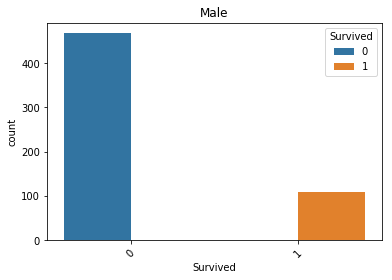

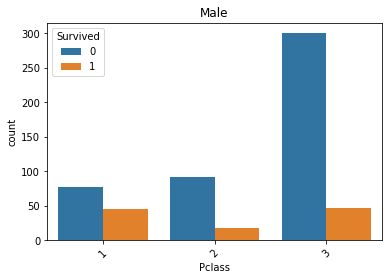

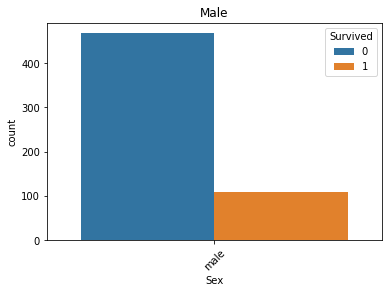

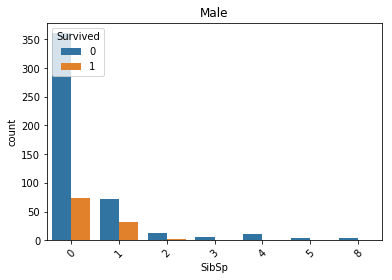

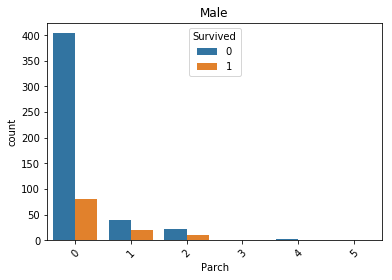

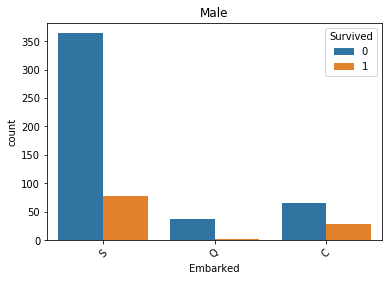

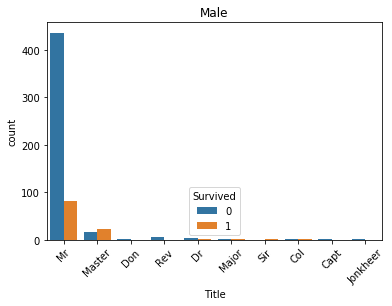

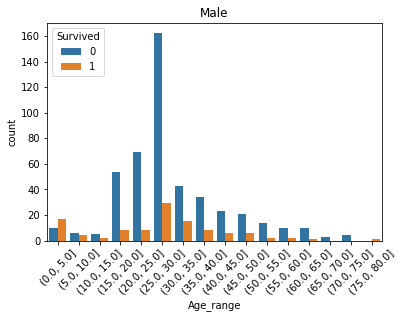

In [18]:
# plot categorical features of df_male based on survival

cate = ['Survived', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'Title', 'Age_range']
for col in cate:
    sns.countplot(df_male[col], hue=df_male['Survived'])
    plt.xticks(rotation=45)
    plt.title('Male')
    plt.show()

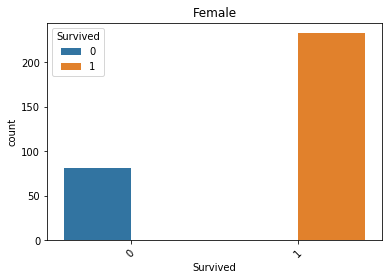

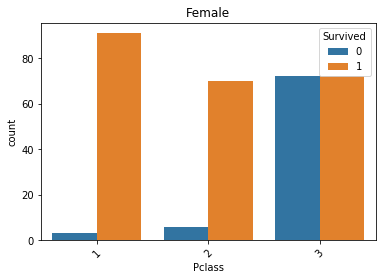

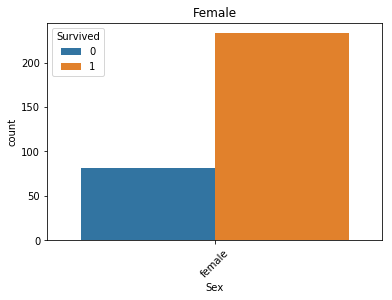

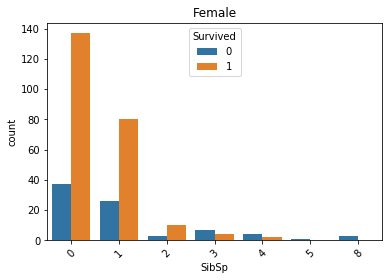

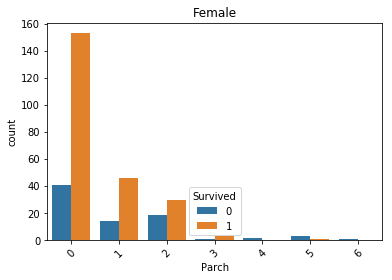

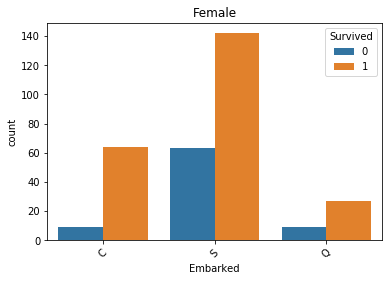

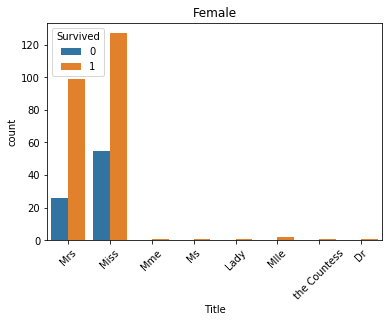

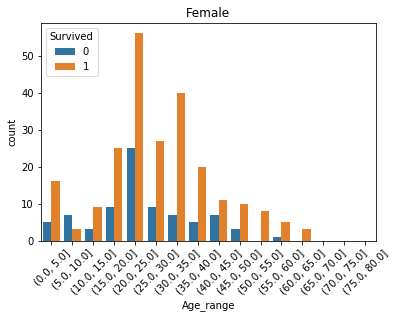

In [19]:
# plot categorical features of df_female based on survival

for col in cate:
    sns.countplot(df_female[col], hue=df_female['Survived'])
    plt.xticks(rotation=45)
    plt.title('Female')
    plt.show()

In [20]:
# focus on Master

df_train[df_train['Title']=='Master'].Age.max()

12.0

Seems that:
* 0-15 years old males tend to survive
* pclass 3 females tend to die

Woman and children were prioritized in rescue?

Since maximum age for 'Master' is 12 years old, all of them are included in 0-15 years old males range. Hence, let's focus on 'Master' and 'female', and their relations.

In [21]:
# determine the survival status of members of families

all_survived = []
all_dead = []
combined = []
surname = df_train[df_train.duplicated(subset='Surname', keep=False)].Surname.unique()

for s in surname:
    x = df_train[(df_train['Surname']==s) & ((df_train.Title=='Master') | (df_train.Sex=='female'))]
    if x.shape[0] >= 2:
        if x['Survived'].all():
            all_survived.append(s)
        elif not x['Survived'].any():
            all_dead.append(s)
        else:
            combined.append(s)

print('Family who all survived      :', sorted(all_survived), '\n')
print('Family who are all dead      :', sorted(all_dead), '\n')
print('Family both survived and dead:', sorted(combined), '\n')

for s in combined:
    print(df_train[(df_train['Surname']==s) & ((df_train.Title=='Master') | (df_train.Sex=='female'))] \
          [['Survived', 'Sex', 'Title', 'Surname']])

Family who all survived      : ['Baclini', 'Becker', 'Brown', 'Caldwell', 'Collyer', 'Coutts', 'Doling', 'Fortune', 'Goldsmith', 'Graham', 'Hamalainen', 'Harper', 'Hart', 'Hays', 'Herman', 'Hippach', 'Johnson', 'Kelly', 'Laroche', 'Mellinger', 'Moor', 'Moubarek', 'Murphy', 'Navratil', 'Newell', 'Nicola-Yarred', 'Peter', 'Quick', 'Richards', 'Ryerson', 'Sandstrom', 'Taussig', 'West', 'Wick'] 

Family who are all dead      : ['Barbara', 'Boulos', 'Bourke', 'Ford', 'Goodwin', 'Jussila', 'Lefebre', 'Palsson', 'Panula', 'Rice', 'Sage', 'Skoog', 'Strom', 'Van Impe', 'Vander Planke', 'Zabour'] 

Family both survived and dead: ['Allison', 'Andersson', 'Asplund', 'Carter'] 

     Survived     Sex   Title    Surname
68          1  female    Miss  Andersson
119         0  female    Miss  Andersson
541         0  female    Miss  Andersson
542         0  female    Miss  Andersson
610         0  female     Mrs  Andersson
813         0  female    Miss  Andersson
850         0    male  Master  Anderss

'Master' and 'female' tend to either survive or die together!!! In fact, only 4 people in the training dataset who violate this condition.

In [22]:
# concatenate

df_train = df_train.set_index('PassengerId')
df_test = df_test.set_index('PassengerId')
df = pd.concat([df_train, df_test], axis=0, sort=False)

In [23]:
# feature engineering

df['IsWomanOrChild'] = (df.Title == 'Master') | (df.Sex == 'female')
family = df.groupby('Surname').Survived
df['FamilyTotalCount'] = family.transform(lambda s: s[df.IsWomanOrChild].fillna(0).count())
df['FamilyTotalCount'] = df.mask(df.IsWomanOrChild, df.FamilyTotalCount - 1, axis=0)
df['FamilySurvivedCount'] = family.transform(lambda s: s[df.IsWomanOrChild].fillna(0).sum())
df['FamilySurvivedCount'] = df.mask(df.IsWomanOrChild, df.FamilySurvivedCount - df.Survived.fillna(0), axis=0)
df['FamilySurvivalRate'] = df.FamilySurvivedCount / df.FamilyTotalCount.replace(0, np.nan)
df['IsSingleTraveler'] = df.FamilyTotalCount == 0

Confused?

The first line of code for 'FamilyTotalCount' calculates the number of 'Master' and 'female' in each family, and assign this number to each family member. The fillna method is used to include 'Master' and 'female' in test dataset as well.

The second line of code for 'FamilyTotalCount' assigns the number of 'Master' and 'female' that a 'Master' or 'female' has in his/her family, and assigns 'Survived' value for each 'non-Master male' row. This calculation is applied for each family.

The similar approach applies for 'FamilySurvivedCount'.

'IsSingleTraveler' separates 'Master' and 'female' who travels alone and non-survivors from other passengers.

In [24]:
# sneak peek at the data

df[['Surname', 'IsWomanOrChild', 'FamilyTotalCount', 'FamilySurvivedCount', 'Survived']].sort_values('Surname')

,Surname,IsWomanOrChild,FamilyTotalCount,FamilySurvivedCount,Survived
PassengerId,,,,,
846,Abbing,False,0,0,0.0
1284,Abbott,True,1,1,NaN
747,Abbott,False,0,0,0.0
280,Abbott,True,1,0,1.0
949,Abelseth,False,NaN,NaN,NaN
1237,Abelseth,True,0,0,NaN
309,Abelson,False,0,0,0.0
875,Abelson,True,0,0,1.0
1143,Abrahamsson,False,NaN,NaN,NaN


In [25]:
# feature selection

x = pd.concat([df.FamilySurvivalRate.fillna(0),
               df.IsSingleTraveler,
               df.Sex.replace({'male': 0, 'female': 1})],
              axis=1)

train_x, test_x = x.loc[df_train.index], x.loc[df_test.index]
train_y = df.Survived.loc[df_train.index]

In [26]:
# build and fit a Decision Tree

clf = tree.DecisionTreeClassifier()
grid = GridSearchCV(clf, cv=5, param_grid={
    'criterion': ['gini', 'entropy'], 
    'max_depth': [2, 3, 4, 5]})
grid.fit(train_x, train_y)
print(grid.best_params_)
print(grid.best_score_)
model = grid.best_estimator_

{'criterion': 'gini', 'max_depth': 3}
0.9214365881032548


In [27]:
# predict

test_y = model.predict(test_x).astype(int)
output = pd.DataFrame({'PassengerId':df_test.index, 'Survived':test_y})
output.to_csv('master & female.csv', index=False)
print('LB score: 0.83253')

LB score: 0.83253
